### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [121]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import tqdm as tqdm
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [122]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
16,NSW17,1,27,13,1,0,0,0,0.000,0.0000,14581.8600
603,PSID419,0,51,4,1,0,0,1,0.000,0.0000,0.0000
237,PSID53,0,41,15,0,0,1,0,25862.320,6563.3230,24647.0000
428,PSID244,0,36,8,0,0,1,1,2715.544,585.4355,0.0000
484,PSID300,0,22,8,1,0,1,1,16961.370,0.0000,959.0445
45,NSW46,1,25,11,1,0,1,1,0.000,0.0000,0.0000
287,PSID103,0,21,12,0,0,0,0,9665.063,4110.5810,1687.5640
399,PSID215,0,35,10,0,0,1,1,4964.782,1086.7260,1745.1950
198,PSID14,0,29,12,0,0,1,0,14768.950,11146.5500,6420.7220
82,NSW83,1,38,12,0,0,0,0,0.000,0.0000,4941.8490


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

In [123]:
# Descriptive statistics
pd.DataFrame({'treated': df[df.treat == 1].re78.describe(), 'control': df[df.treat == 0].re78.describe()})

,treated,control
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000


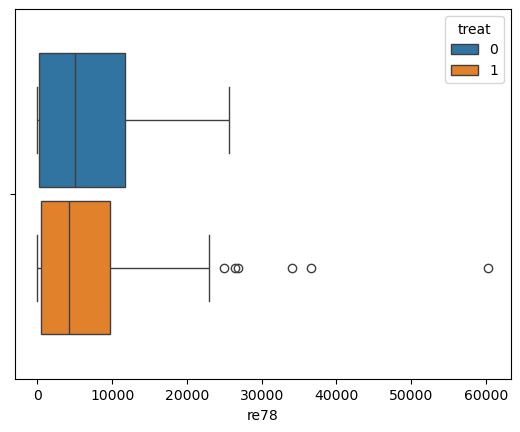

In [124]:
# Boxplot
sns.boxplot(data=df, x='re78', hue='treat', gap=0.1)
plt.show()

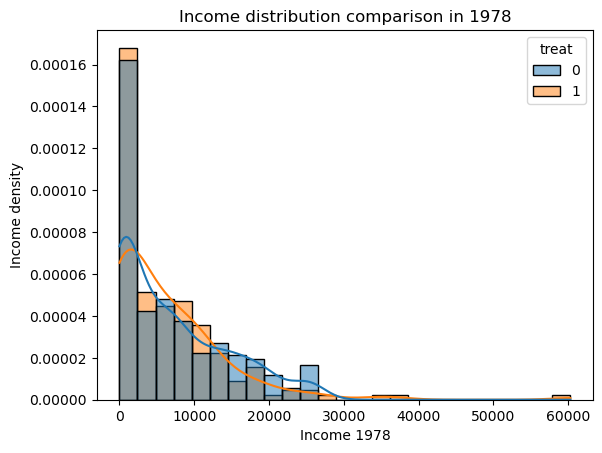

In [125]:
# Historgram
ax = sns.histplot(data=df, x='re78', hue='treat', kde=True, stat='density', common_norm=False)
ax.set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Income density')
plt.show()

In [194]:
# t-test
from statsmodels.stats.nonparametric import rank_compare_2indep 
res = rank_compare_2indep(df[df.treat == 0].re78, df[df.treat == 1].re78)
print(res.summary())

                  Probability sample 1 is stochastically larger                   
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
prob(x1>x2) c0     0.5272      0.025      1.101      0.272       0.479       0.576


In [127]:
# Confidence interval
def bootstrap_confidence_interval(data, iterations=1000):
    """
    Bootstrap the 95% confidence interval for the mean of the data.
    
    Parameters:
    - data: An array of data
    - iterations: The number of bootstrap samples to generate
    
    Returns:
    - A tuple representing the lower and upper bounds of the 95% confidence interval
    """
    means = np.zeros(iterations)
    
    for i in range(iterations):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        means[i] = np.mean(bootstrap_sample)
        
    lower_bound = np.percentile(means, 2.5)
    upper_bound = np.percentile(means, 97.5)
    
    return (lower_bound, upper_bound)

Confidence interval of the mean real earning of the control group: [6279, 7609]
Confidence interval of the mean real earning of the treated group: [5293, 7439]


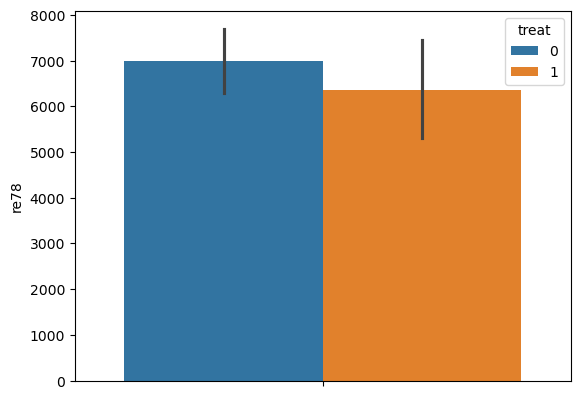

In [128]:
lower_bound1, upper_bound1 = bootstrap_confidence_interval(df[df.treat == 1].re78)
lower_bound0, upper_bound0 = bootstrap_confidence_interval(df[df.treat == 0].re78)
print(f'Confidence interval of the mean real earning of the control group: [{lower_bound0:.0f}, {upper_bound0:.0f}]')
print(f'Confidence interval of the mean real earning of the treated group: [{lower_bound1:.0f}, {upper_bound1:.0f}]')

# Barplot of confidence interval
sns.barplot(df, y='re78', hue='treat', errorbar=('ci', 95))
plt.show()

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [129]:
def ethnicity(subject):
    if subject.black: return 'black'
    elif subject.hispan: return 'hispan'
    else: return 'white'

df['ethnicity'] = df.apply(lambda x: ethnicity(x), axis=1)
cols = ['age', 'educ', 'married', 'nodegree','re74', 're75']

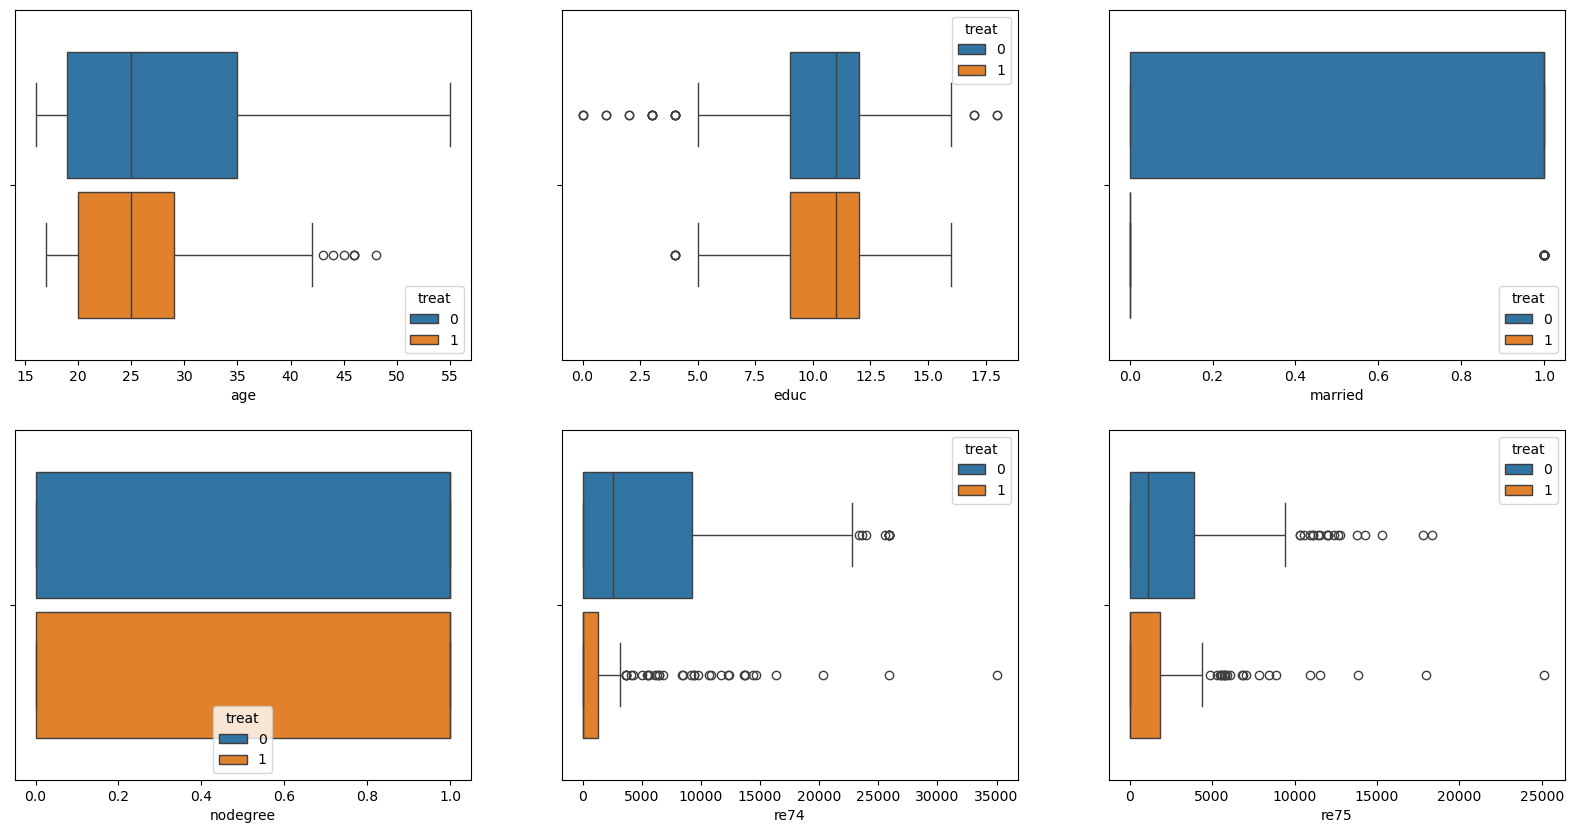

In [130]:
# Boxplot
fig, axes = plt.subplots(2,3, figsize=(20, 10))
axes = axes.flatten()
for col, ax in zip(cols, axes):
    sns.boxplot(data=df, x=col, hue='treat', gap=0.1, ax=ax)
plt.show()

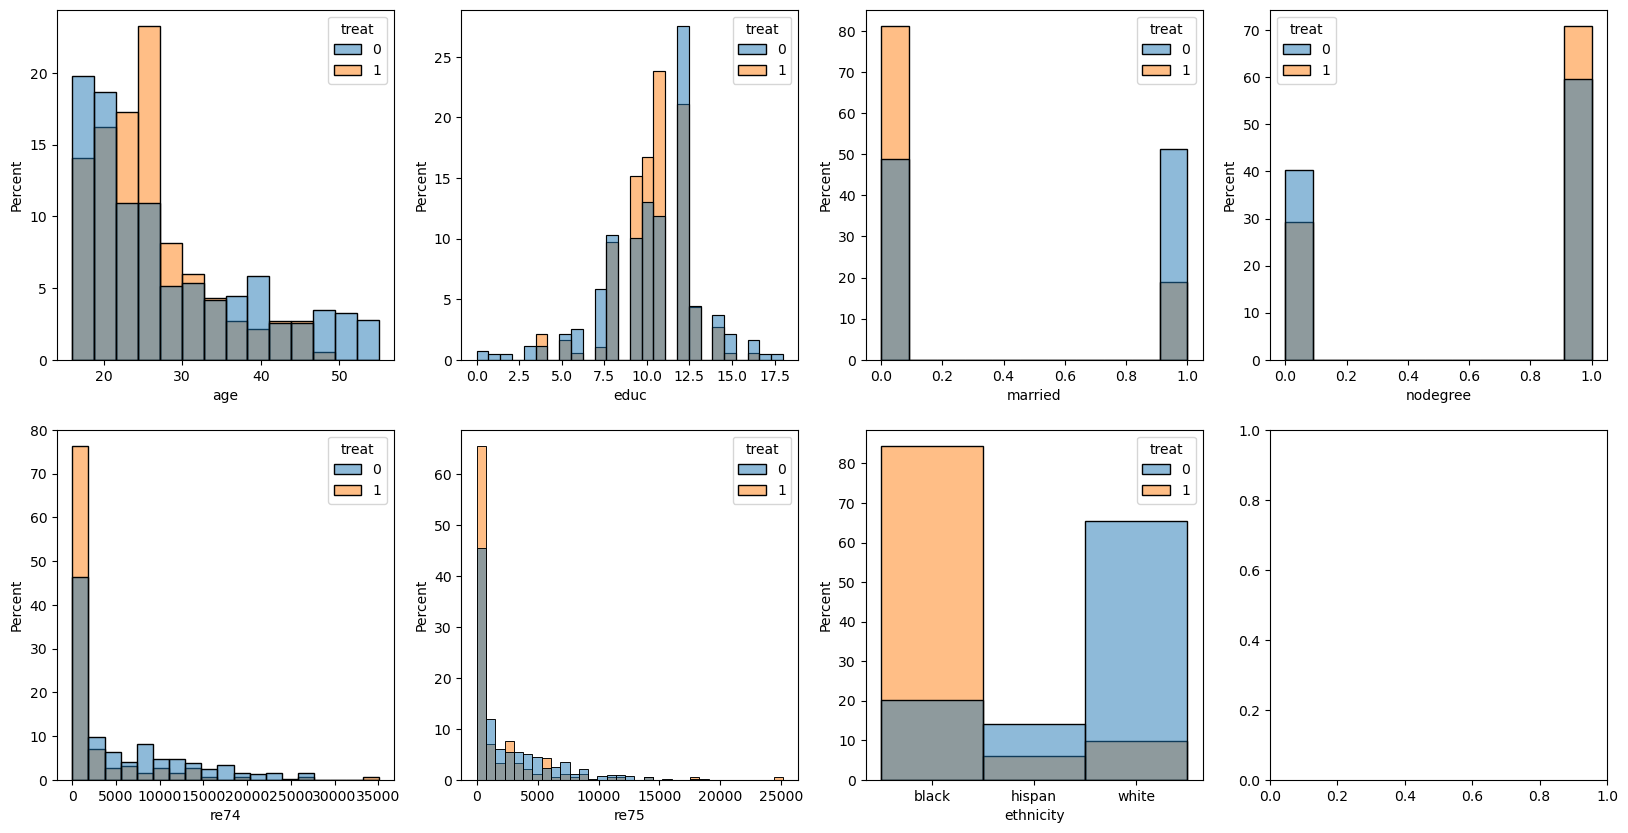

In [131]:
# Histogram
fig, axes = plt.subplots(2,4, figsize=(20, 10))
axes = axes.flatten()
for col, ax in zip(cols + ['ethnicity'], axes):
    sns.histplot(data=df, x=col, hue='treat', ax=ax, stat='percent', common_norm=False)
plt.show()


As we can observe from this plot, the number of treated members that were unemployed before the training program is quite high. So this might give us an intuition of how much the program helped people to find a job, independently of the income that they got eventually. 

The percentage of unmarried people between the treated group is much higher than the married ones whereas in the control group, the two categories are balanced. This might be an indication of what type of people are included in the program.

White outnumber the other races in the control group, and on the 
other hand, in the treated group the proportion of black is almost 
the only one




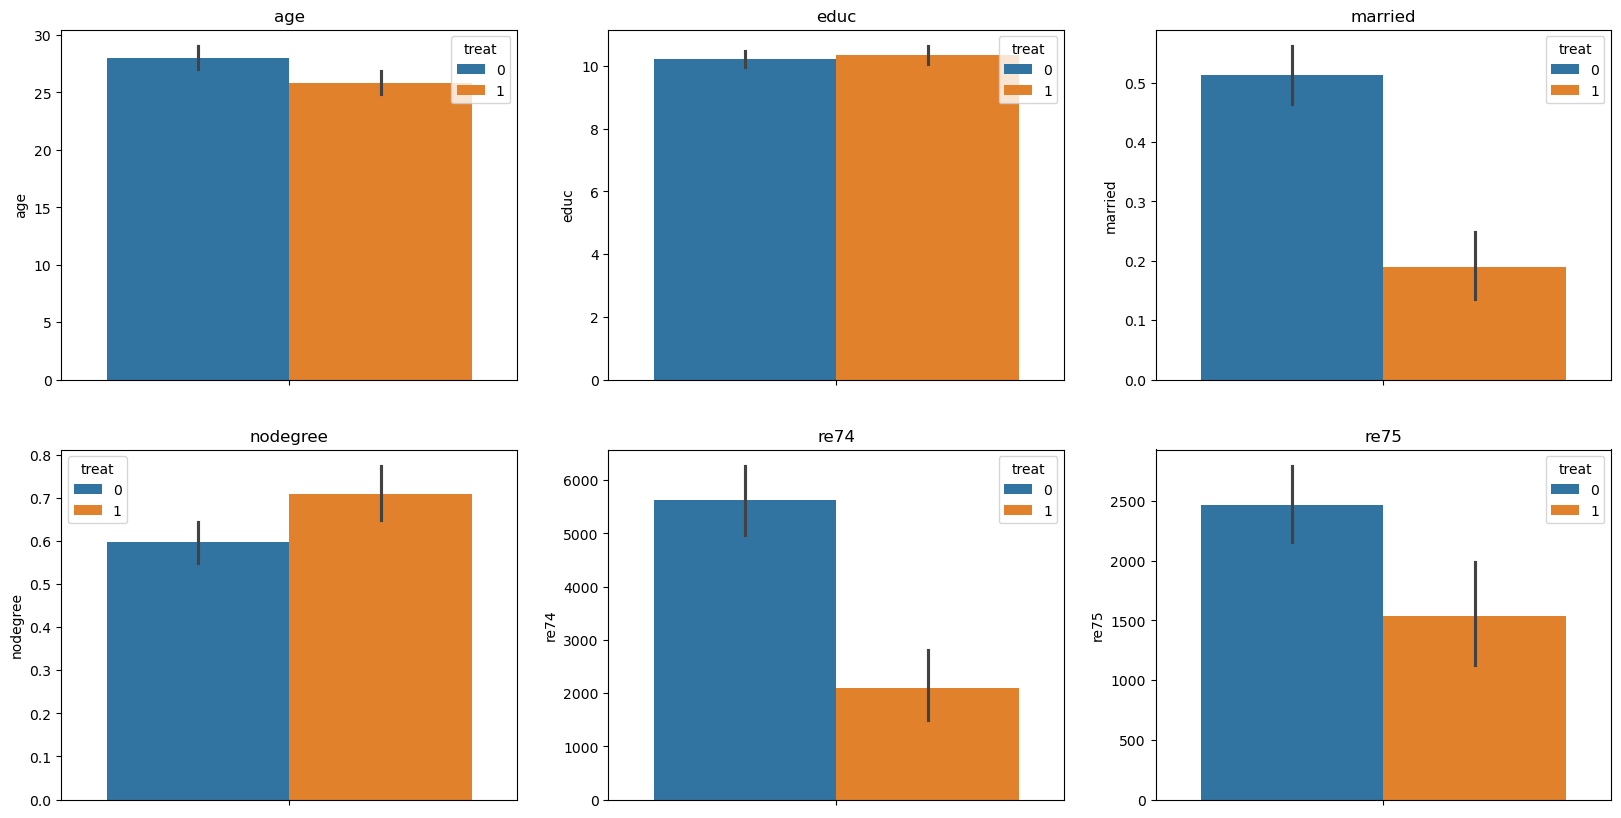

In [132]:
# Confidence interval of the mean
fig, axes = plt.subplots(2,3, figsize=(20, 10))
axes = axes.flatten()
for col, ax in zip(cols, axes):
    sns.barplot(df, y=col, hue='treat', errorbar=('ci', 95), ax=ax)
    ax.set_title(col)
plt.show()

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [133]:
import statsmodels.formula.api as smf

In [134]:
for col in ['age', 'educ', 're74', 're75']:
    df[col] = (df[col] - df[col].mean()) / df[col].std()

In [135]:
mod = smf.logit(data=df, formula='treat ~ age + educ + C(black) + C(hispan) + C(married) + C(nodegree) + re74 + re75').fit()
df['propensity'] = mod.predict()
print(mod.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:                  0.3508
Time:                        16:02:01   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
- G = nx.Graph()
- G.add_weighted_edges_from([(control_person, treated_person, similarity)])

Optimal matching is then found with:
- matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [136]:
def similarity(propensity1, propensity2):
    '''Calculate similarity for instances with given propensity scores'''
    return 1-np.abs(propensity1 - propensity2)

In [155]:
# Create an empty undirected graph
G = nx.Graph()
# Split the 2 groups
treated = df[df.treat == 1]
control = df[df.treat == 0]

# Add the subjects to the graph and edge's weight as the similarity of propoensity score between subjects  
for subject1 in control.itertuples(index=False):
    for subject2 in treated.itertuples(index=False):
        G.add_edge(subject1, subject2, weight=similarity(subject1.propensity, subject2.propensity))

matching = nx.max_weight_matching(G)
df_balanced = pd.DataFrame([subject for pair in matching for subject in pair])

# Real earning after treatment comparison

In [157]:
# Descriptive statistics
pd.DataFrame({'treated': df_balanced[df_balanced.treat == 1].re78.describe(), 'control': df_balanced[df_balanced.treat == 0].re78.describe()})

,treated,control
count,185.000000,185.000000
mean,6349.143530,5454.776050
std,7867.402218,6063.836916
min,0.000000,0.000000
25%,485.229800,0.000000
50%,4232.309000,3358.873000
75%,9642.999000,7933.914000
max,60307.930000,23764.800000


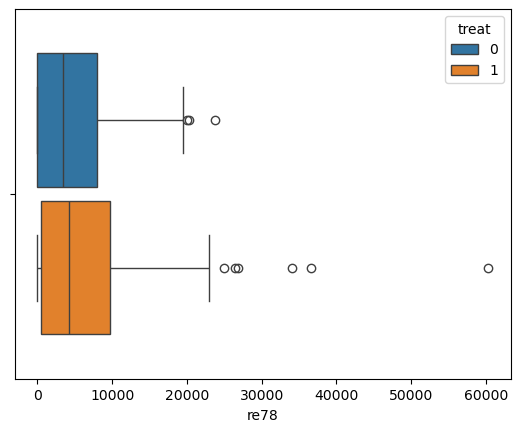

In [158]:
# Boxplot
sns.boxplot(data=df_balanced, x='re78', hue='treat', gap=0.1)
plt.show()

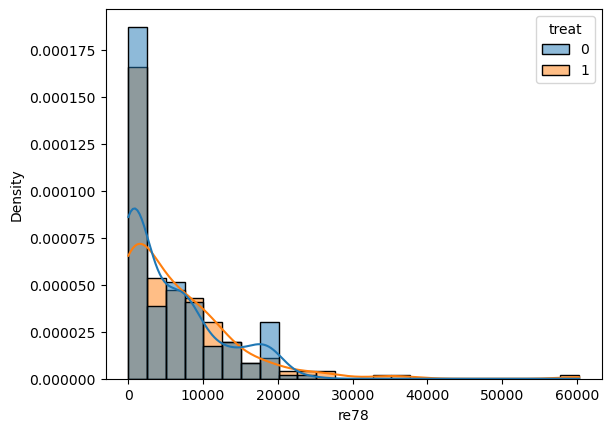

In [159]:
# Historgram
sns.histplot(data=df_balanced, x='re78', hue='treat', kde=True, stat='density', common_norm=False)
plt.show()

In [197]:
# t-test
res = rank_compare_2indep(df_balanced[df_balanced.treat == 1].re78, df_balanced[df_balanced.treat == 0].re78)
print(res.summary())

statistic = 0.8278257494484492
pvalue = 0.4083057079521917
s1 = 2829.778613396005
s2 = 2815.574809048179
var1 = 0.08268162493487231
var2 = 0.08226661239001253
var = 0.3298964746497697
var_prob = 0.0008916120936480261
nobs1 = 185
nobs2 = 185
nobs = 370
mean1 = 190.07297297297296
mean2 = 180.92702702702704
prob1 = 0.5247187728268808
prob2 = 0.4752812271731191
somersd1 = 0.04943754565376168
somersd2 = -0.049437545653761794
df = 367.9976704493322
use_t = True
tuple = (0.8278257494484492, 0.4083057079521917)
                  Probability sample 1 is stochastically larger                   
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
prob(x1>x2) c0     0.5247      0.030      0.828      0.408       0.466       0.583


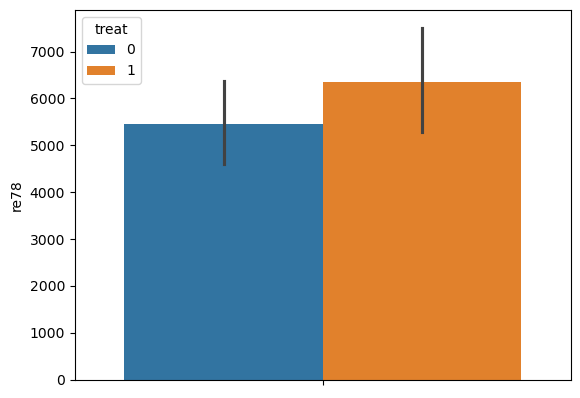

In [161]:
# Barplot of confidence interval
sns.barplot(df_balanced, y='re78', hue='treat', errorbar=('ci', 95))
plt.show()


## Other features comparison

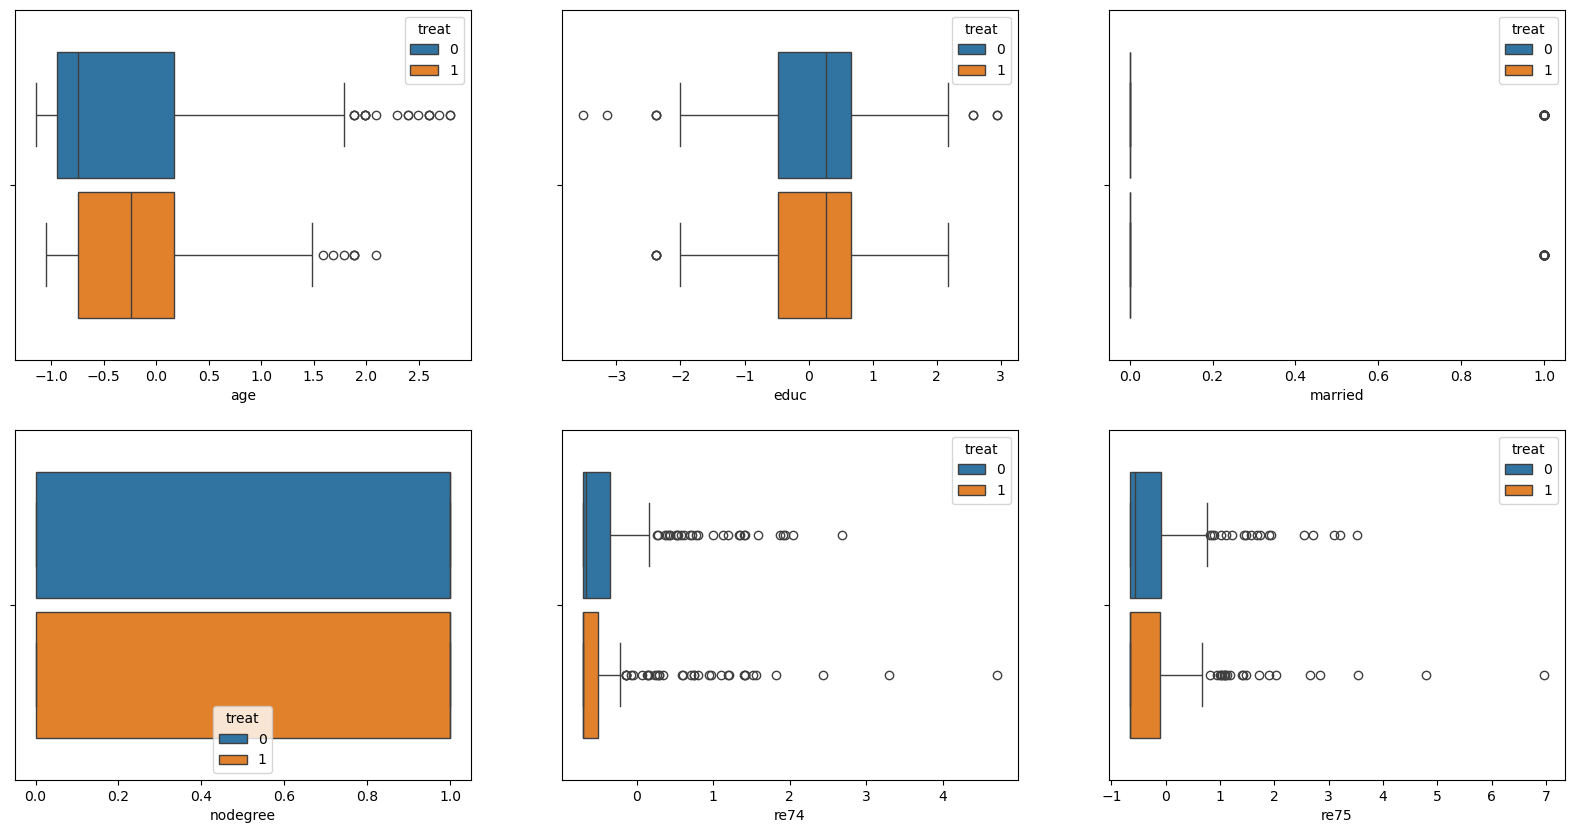

In [162]:
# Boxplot
fig, axes = plt.subplots(2,3, figsize=(20, 10))
axes = axes.flatten()
for col, ax in zip(cols, axes):
    sns.boxplot(data=df_balanced, x=col, hue='treat', gap=0.1, ax=ax)
plt.show()

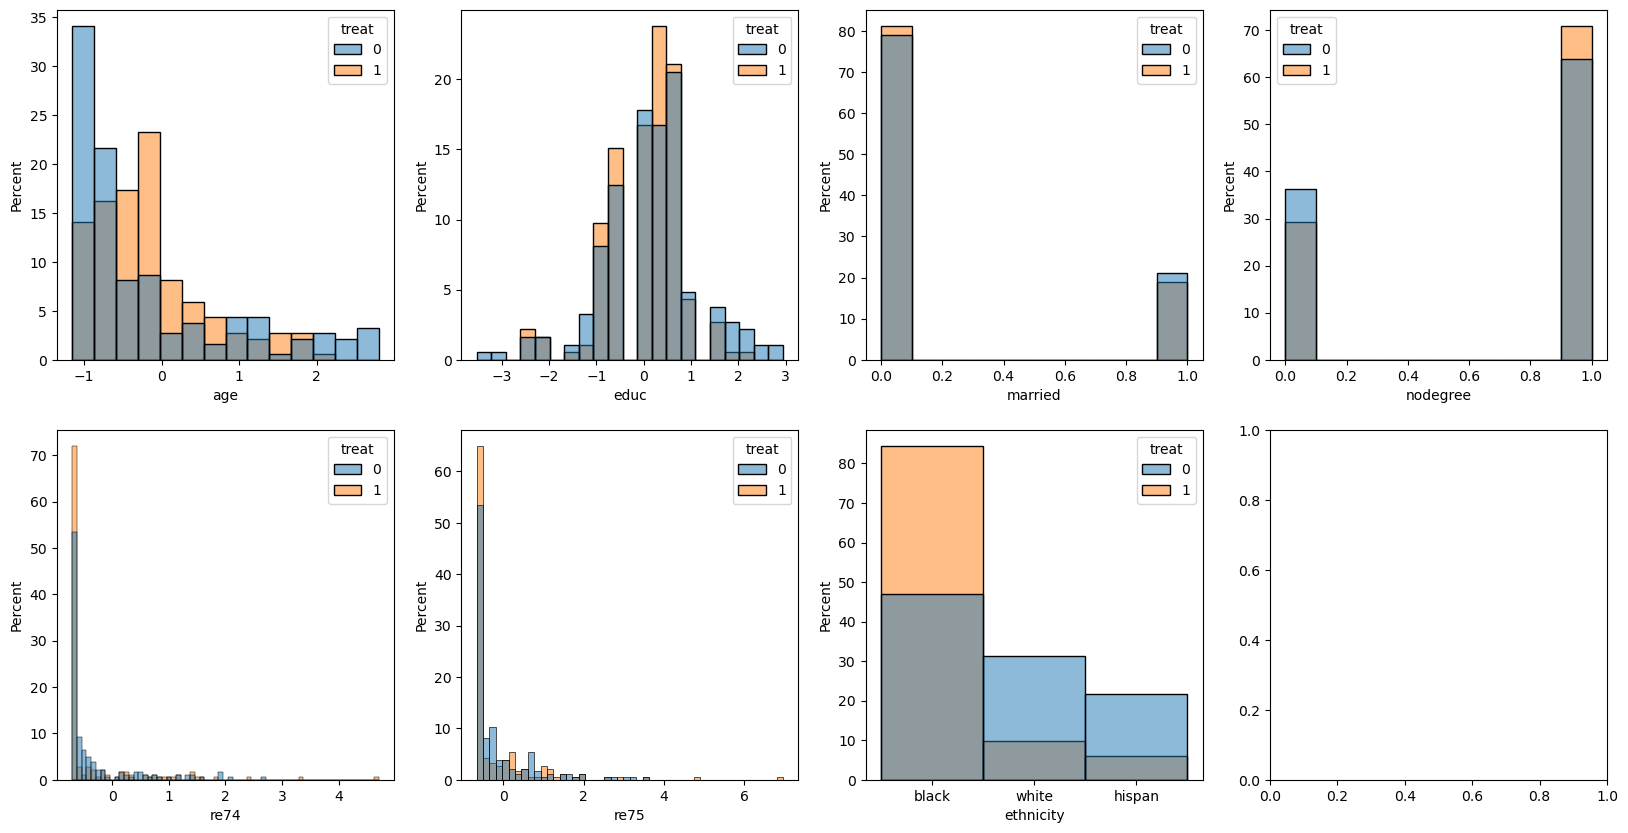

In [163]:
# Histogram
fig, axes = plt.subplots(2,4, figsize=(20, 10))
axes = axes.flatten()
for col, ax in zip(cols + ['ethnicity'], axes):
    sns.histplot(data=df_balanced, x=col, hue='treat', ax=ax, stat='percent', common_norm=False)
plt.show()


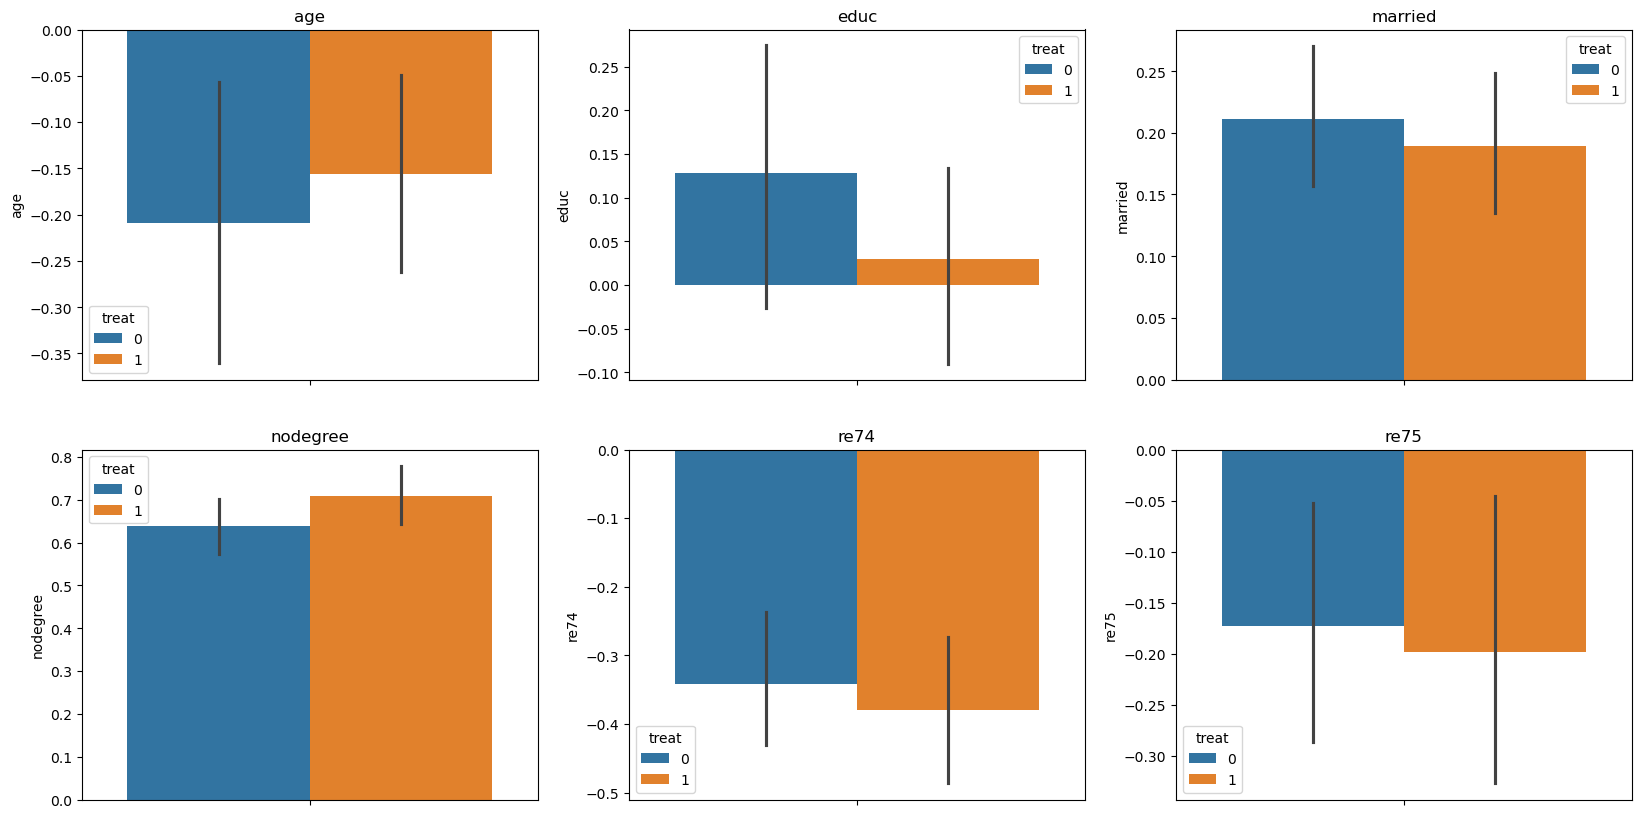

In [164]:
# Confidence interval of the mean
fig, axes = plt.subplots(2,3, figsize=(20, 10))
axes = axes.flatten()
for col, ax in zip(cols, axes):
    sns.barplot(df_balanced, y=col, hue='treat', errorbar=('ci', 95), ax=ax)
    ax.set_title(col)
plt.show()

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


Black and hispanic ethnicities are still not balanced and it might happen that, for example, black people that tend to do the program more often have also less chance of increasing their earning through the years because of some underlying discrimination. And in opposite way for hispanic people. 

In [166]:
# Create the graph
G_bis = nx.Graph()
# Split the 2 groups
treated = df[df.treat == 1]
control = df[df.treat == 0]

# Add the subjects to the graph and edge's weight as the similarity of propoensity score between subjects  
for subject1 in control.itertuples(index=False):
    for subject2 in treated.itertuples(index=False):
        if (subject1.black == subject2.black) and (subject1.hispan == subject2.hispan):
            G_bis.add_edge(subject1, subject2, weight=similarity(subject1.propensity, subject2.propensity))

matching_bis = nx.max_weight_matching(G_bis)
df_balanced_bis = pd.DataFrame([subject for pair in matching_bis for subject in pair])

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [167]:
# Descriptive statistics
pd.DataFrame({'treated': df_balanced_bis[df_balanced_bis.treat == 1].re78.describe(), 'control': df_balanced_bis[df_balanced_bis.treat == 0].re78.describe()})

,treated,control
count,116.000000,116.000000
mean,6375.738003,5095.456025
std,6670.986821,6047.014862
min,0.000000,0.000000
25%,758.102600,0.000000
50%,4648.736000,2256.488500
75%,10160.440000,8942.092750
max,36646.950000,20243.380000


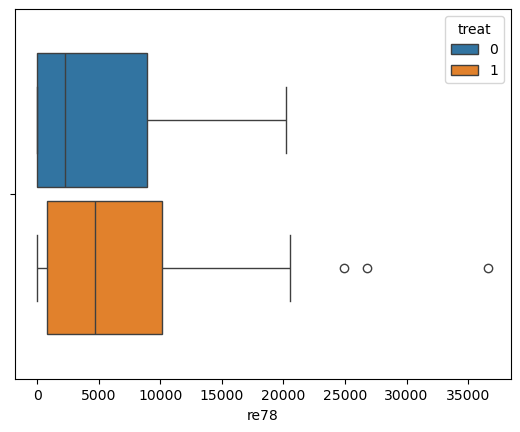

In [168]:
# Boxplot
sns.boxplot(data=df_balanced_bis, x='re78', hue='treat', gap=0.1)
plt.show()

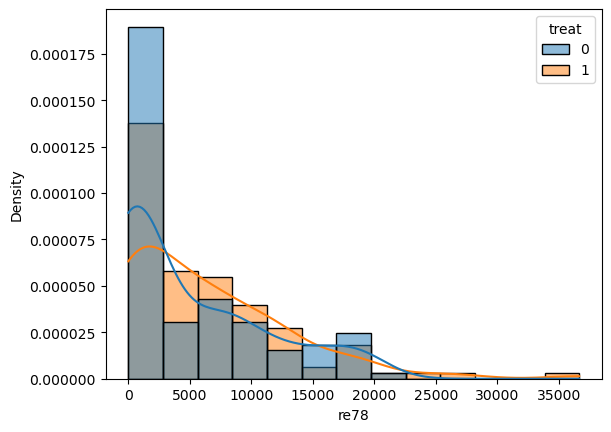

In [172]:
# Historgram
sns.histplot(data=df_balanced_bis, x='re78', hue='treat', kde=True, stat='density', common_norm=False)
plt.show()

In [ ]:
sns.histplot(data=df_balanced_bis, x='log_re78', hue='treat', kde=True, stat='density', common_norm=False)
plt.show()

In [202]:
# t-test
res = rank_compare_2indep(df_balanced_bis[df_balanced_bis.treat == 1].re78, df_balanced_bis[df_balanced_bis.treat == 0].re78)
print(res.summary())

                  Probability sample 1 is stochastically larger                   
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
prob(x1>x2) c0     0.5663      0.038      1.762      0.079       0.492       0.640


In [203]:
from scipy.stats import mannwhitneyu
mannwhitneyu(df_balanced_bis[df_balanced_bis.treat == 1].re78, df_balanced_bis[df_balanced_bis.treat == 0].re78)

MannwhitneyuResult(statistic=7620.0, pvalue=0.07900133821905235)

Confidence interval of the mean real earning of the control group: [4085, 6203]
Confidence interval of the mean real earning of the treated group: [5164, 7727]


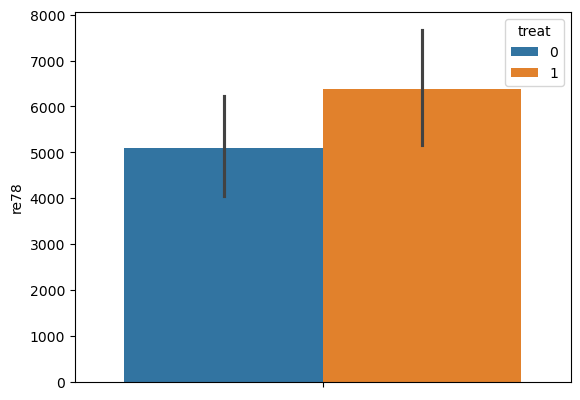

In [171]:
# Confidence interval
lower_bound1, upper_bound1 = bootstrap_confidence_interval(df_balanced_bis[df_balanced_bis.treat == 1].re78)
lower_bound0, upper_bound0 = bootstrap_confidence_interval(df_balanced_bis[df_balanced_bis.treat == 0].re78)
print(f'Confidence interval of the mean real earning of the control group: [{lower_bound0:.0f}, {upper_bound0:.0f}]')
print(f'Confidence interval of the mean real earning of the treated group: [{lower_bound1:.0f}, {upper_bound1:.0f}]')

# Barplot of confidence interval
sns.barplot(df_balanced_bis, y='re78', hue='treat', errorbar=('ci', 95))
plt.show()


Final conclusion: after the propensity score matching, the results drastically change and support the positive effect of the training program.